In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_pow_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [7]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_path, dtype=dtype)
windmill = windmill[windmill["Turbine_type"]=="P"][windmill["Placement"]=="HAV"]

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [8]:
len(windmill)

13

In [9]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [10]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [11]:
df = features.parallelize_extract(df)

parallelize_extract time:  1267.6268758773804


In [7]:
# df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
# df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [12]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [13]:
df['VAERDI'] = df['VAERDI'] / df['max_VAERDI'] 
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [33]:
cols = [x for x in df.columns if x not in cols_filter]
df[cols] = tools.normalize_zcenter(df[cols])
df[cols] = df[cols].fillna(0)
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [34]:
len(df_train)

197784

In [35]:
df_train.to_parquet(constant.PH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PH_SC_EVL_path, index=False)

# Neural Network Train

In [17]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)
df_evl = pd.read_parquet(constant.SL_SC_EVL_path)

In [18]:
target = ["VAERDI"]
# n_groups=10
lr=0.01
num_epochs=30
f_active = "tanh"
hidden_size = 1000
output_size = 1

## Original Features


### Timeserise K-Fold-Validation

In [19]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

In [20]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [21]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

x_test, y_test = df_evl[org_cols].values, df_evl[target].values
x_test_tensor = torch.tensor(x_test, dtype = torch.float)
y_test_tensor = torch.tensor(y_test, dtype = torch.float)

In [22]:
input_size = 45
model_original, train_hist_original, test_hist_original = train_model(
                                            input_size,
                                            hidden_size,
                                            f_active,
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            x_test_tensor,
                                            y_test_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.06881853193044662 test loss: 0.08439067006111145
Epoch 10 train loss: 0.05951116234064102 test loss: 0.10853176563978195
Epoch 20 train loss: 0.026296451687812805 test loss: 0.039403412491083145
Epoch 29 train loss: 0.02259713038802147 test loss: 0.03707234933972359


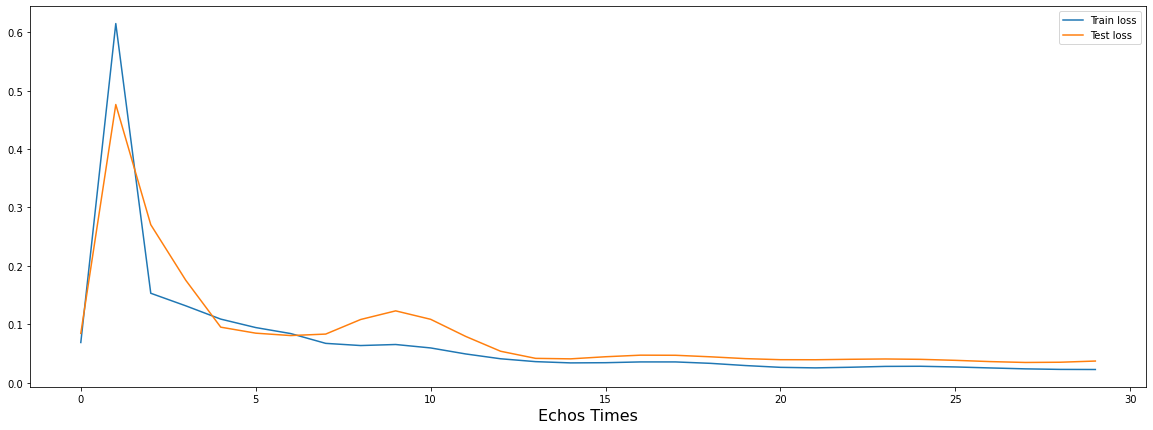

In [23]:
myplot.model_loss({"Train loss":train_hist_original, "Test loss":test_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [24]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

In [25]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [26]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

x_test, y_test = df_evl[wsr_cols].values, df_evl[target].values
x_test_tensor = torch.tensor(x_test, dtype = torch.float)
y_test_tensor = torch.tensor(y_test, dtype = torch.float)

In [27]:
input_size = 44
model_wsr, train_hist_wsr, test_hist_wsr = train_model(input_size,
                                            hidden_size,
                                            f_active,
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            x_test_tensor,
                                            y_test_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.07639583200216293 test loss: 0.08018966764211655
Epoch 10 train loss: 0.035721153020858765 test loss: 0.056069180369377136
Epoch 20 train loss: 0.01539849117398262 test loss: 0.016070419922471046
Epoch 29 train loss: 0.011824027635157108 test loss: 0.014881274662911892


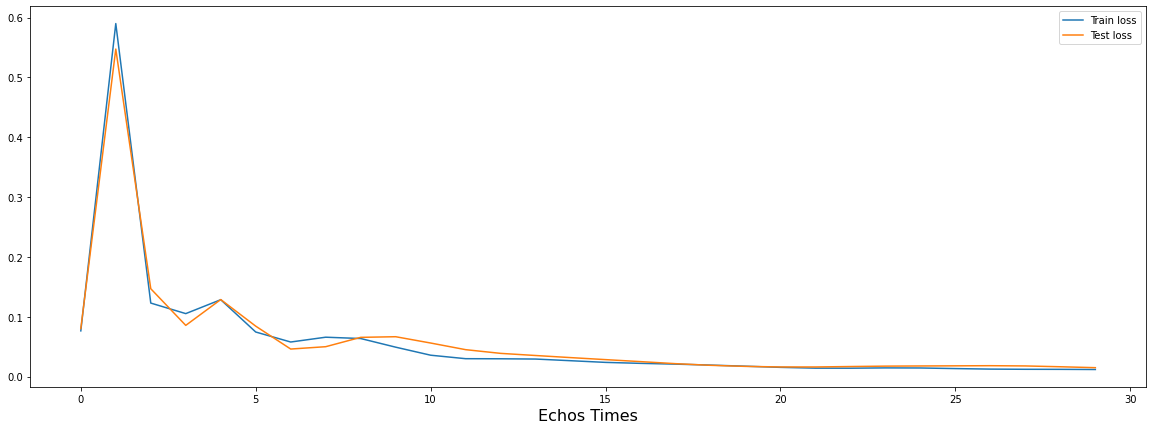

In [28]:
myplot.model_loss({"Train loss":train_hist_wsr, "Test loss":test_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [29]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

In [30]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [31]:
x_train, y_train = df_train[geo_pow_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

x_test, y_test = df_evl[geo_pow_cols].values, df_evl[target].values
x_test_tensor = torch.tensor(x_test, dtype = torch.float)
y_test_tensor = torch.tensor(y_test, dtype = torch.float)

In [32]:
input_size=46
model_geo, train_hist_geo, test_hist_geo = train_model(input_size,
                                            hidden_size,
                                            f_active,
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor, 
                                            x_test_tensor,
                                            y_test_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.0638221725821495 test loss: 0.13491323590278625
Epoch 10 train loss: 0.0377938486635685 test loss: 0.04527333378791809
Epoch 20 train loss: 0.014101924374699593 test loss: 0.01589108072221279
Epoch 29 train loss: 0.010943787172436714 test loss: 0.024359237402677536


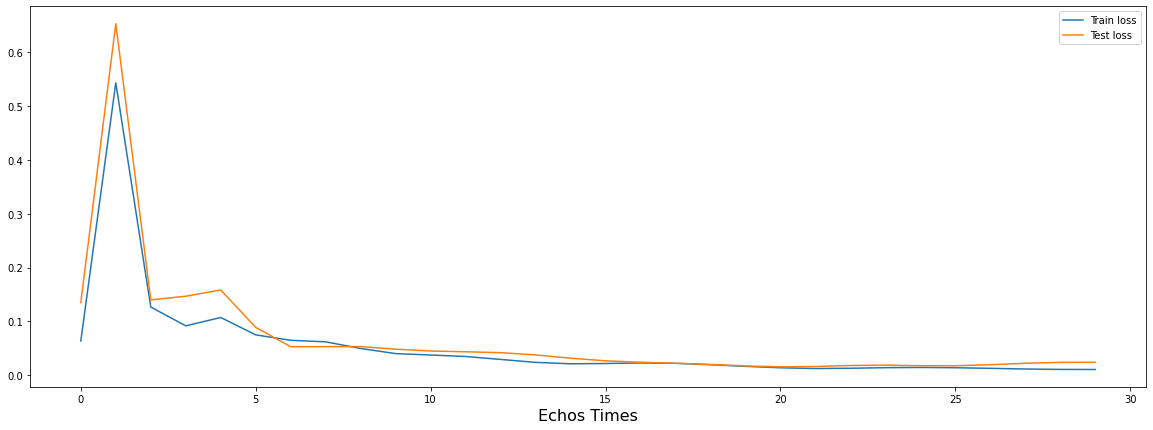

In [33]:
myplot.model_loss({"Train loss":train_hist_geo,"Test loss":test_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [34]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

In [35]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [36]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

x_test, y_test = df_evl[semigeo_cols].values, df_evl[target].values
x_test_tensor = torch.tensor(x_test, dtype = torch.float)
y_test_tensor = torch.tensor(y_test, dtype = torch.float)

In [37]:
input_size = 47
model_semigeo, train_hist_semigeo, test_hist_semigeo = train_model(input_size,
                                            hidden_size,
                                            f_active,
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            x_test_tensor,
                                            y_test_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.07878462225198746 test loss: 0.16398613154888153
Epoch 10 train loss: 0.04201827570796013 test loss: 0.04016222804784775
Epoch 20 train loss: 0.013556442223489285 test loss: 0.016432365402579308
Epoch 29 train loss: 0.010478120297193527 test loss: 0.019041309133172035


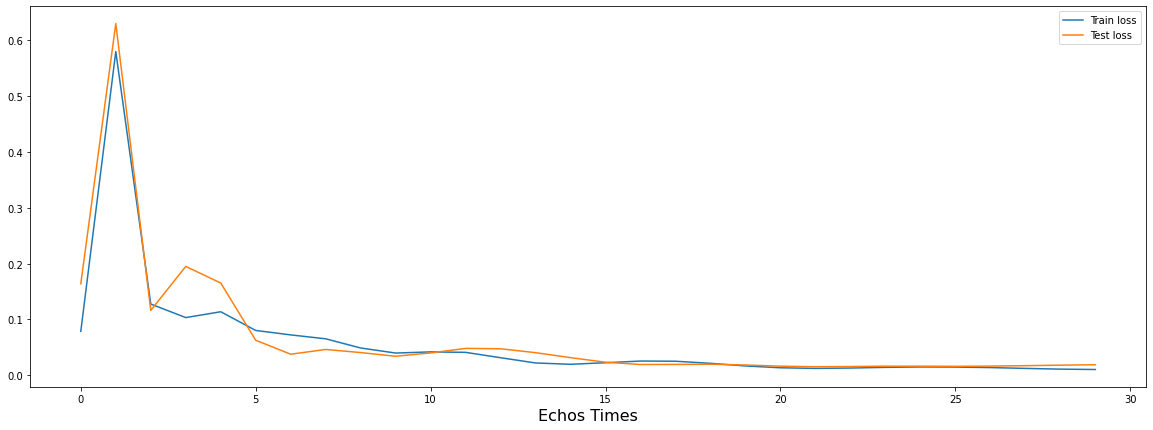

In [38]:
myplot.model_loss({"Train loss":train_hist_semigeo, "Test loss":test_hist_semigeo}, path=plot_path+"semigeo_loss.png")